코랩 기준 설치 후 런타임 재시작을 해야합니다.

In [ ]:
! pip install geopandas
! pip install pydeck
! pip install mip

# 한글 matplotlib 시각화를 위한 폰트 설치 
! sudo apt-get install -y fonts-nanum
! sudo fc-cache -fv
! rm ~/.cache/matplotlib -rf

# 24시간 응급체계를 위한 실외 AED 위치 선정 - STAI 팀

In [1]:
import pandas as pd
import numpy as np
import time
import os
import base64
import re
import random
import pickle
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 
import seaborn as sns
import datetime
from datetime import datetime
import geopandas as gpd
import pydeck as pdk
from shapely import wkt
from tqdm import tqdm
from mip import *
os.chdir('/content/drive/MyDrive/ML_projects/DSF/test')

def multipolygon_to_coordinates(x): 
    lon, lat = x[0].exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)] 

def polygon_to_coordinates(x): 
    lon, lat = x.exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)] 

def image_to_data_url(filename):
    ext = filename.split('.')[-1]
    prefix = f'data:image/{ext};base64,'
    with open(filename, 'rb') as f:
        img = f.read()
    return prefix + base64.b64encode(img).decode('utf-8')

# https://www.flaticon.com/kr/authors/kanyanee-watanajitkasem
AED_ICON = './free-icon-aed-6417086.png'
icon = image_to_data_url(AED_ICON)
icon_data = {
    "url": icon,
    "width": 128,
    "height": 128,
    "anchorY": 128,
}

# 동대문구 행동별 경계면 폴리곤 데이터 
with open('./seoul_boundary.pickle', 'rb') as f:
    boundary = pickle.load(f)

boundary = boundary[boundary['구'] == '동대문구']

# Preprocess & EDA

## 1. 성별, 연령대별 심정지 발생 현황 

### 1-1) 성별 심정지 발생 현황
- 사용 데이터 : 전체_발생건수.csv
- 급성심장정지조사의 전국 심정지 환자 발생 데이터(2019)를 활용한 시각화
- 남성이 65.2%, 여성이 34.8%로 남성이 여성보다 2배에 가깝게 많이 발생

In [2]:
occur = pd.read_csv("./전체_발생건수.csv", encoding='cp949')
seoul = occur[occur['시도별(1)'] == '서울']
seoul = seoul.drop([seoul.index[3], seoul.index[-1]])
sper = seoul.T[2::2]
sper

,15,16,17,19,20,21,22,23,24,25,26,27
성별 및 연령별(2),소계,남자,여자,0~9세,10~19세,20~29세,30~39세,40~49세,50~59세,60~69세,70~79세,80세 이상
2012.1,15.0,64.2,35.8,1.3,1.0,3.0,5.6,8.9,17.5,16.8,23.7,22.3
2013.1,15.7,64.4,35.5,1.4,1.3,3.0,5.5,8.6,17.0,16.6,23.4,23.1
2014.1,16.1,62.5,37.4,1.1,1.1,2.4,5.0,8.0,15.7,16.4,24.1,25.9
2015.1,15.6,63.8,36.1,1.2,1.2,2.9,4.7,8.6,15.0,15.9,25.1,25.2
2016.1,15.3,63.5,36.5,1.1,0.8,3.1,4.5,9.1,15.3,16.6,24.8,24.7
2017.1,15.6,65.7,34.3,0.8,0.9,2.9,4.3,8.5,15.4,17.3,24.6,25.3
2018.1,15.4,64.4,35.6,1.0,1.3,2.4,4.0,8.1,14.2,17.4,24.4,27.2
2019.1,14.4,65.2,34.8,1.1,1.1,3.1,3.8,7.0,14.1,17.7,23.9,28.1


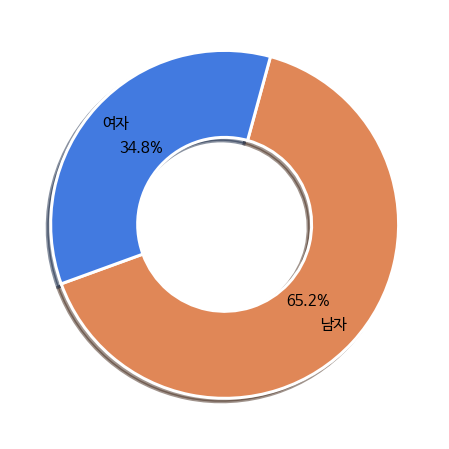

In [3]:
ratio = list(sper.iloc[-1, 1:3].astype(float))
labels = list(sper.iloc[0, 1:3])
plt.figure(figsize=(8,8))

patches, texts, autotexts = plt.pie(ratio, labels=labels, 
                                    autopct='%1.1f%%', 
                                    shadow=True, 
                                    startangle=200,
                                    pctdistance = 0.65,
                                    labeldistance = 0.85,
                                    colors = ['#E08757', '#427AE0'],
                                    wedgeprops = {'width':0.5,'edgecolor':'w','linewidth':3},
                                    textprops = {'size' : 15}
                                    )
# Customize text labels
for text in texts:
    text.set_horizontalalignment('center')

# Customize percent labels
for autotext in autotexts:
    autotext.set_horizontalalignment('center')
    autotext.set_fontstyle('italic')

plt.show()

### 1-2) 연령대 별 심정지 발생 현황
- 80세 이상이 28.1%, 70대가 23.9%, 60대가 17.7%로 나이대가 높을수록 전체 심정지 환자에서 많은 비율을 차지한다.
- 50세 이상이 전체의 84%를 차지한다.
- 나이대에 따라 심정지 발생률이 확실히 다르므로 심정지 발생 예상인구 추측에 고려해야한다.

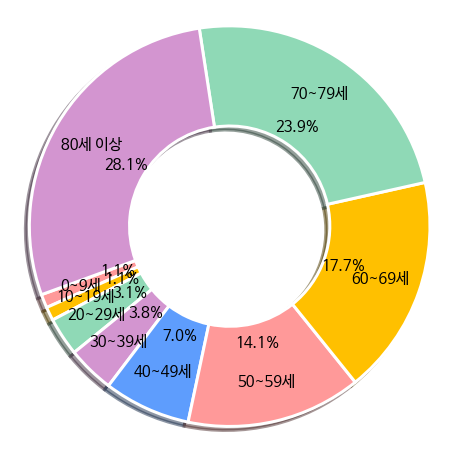

In [4]:
import matplotlib.pyplot as plt
ratio = list(sper.iloc[-1, 3:].astype(float))
labels = list(sper.iloc[0, 3:])

# Plot
plt.figure(figsize=(8,8))
patches, texts, autotexts = plt.pie(ratio, labels=labels, 
                                    autopct='%1.1f%%', 
                                    shadow=True, 
                                    startangle=200,
                                    pctdistance = 0.6,
                                    labeldistance = 0.8,
                                    colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0', '#5E9DFD'],
                                    wedgeprops = {'width':0.5,'edgecolor':'w','linewidth':3},
                                    textprops = {'size' : 15}
                                    )
# Customize text labels
for text in texts:
    text.set_horizontalalignment('center')

# Customize percent labels
for autotext in autotexts:
    autotext.set_horizontalalignment('center')
    autotext.set_fontstyle('italic')

plt.axis('equal')
plt.show()

## 2. 인구 데이터 - 동별 인구 수요량(a)
- 사용 데이터 : 동대문구_동별_연령대별_인구수.csv
- 동대문구의 동별로 성별, 나이대별 인구 데이터에 2020년 급성심장정지 조사에서 발표한 전국 성별, 나이대별 심정지 발생 비율을 weighted sum해서 구함

In [5]:
pop = pd.read_csv('./동대문구_동별_연령대별_인구수.csv')

cols = pop.columns
pop['male'] = pop[cols[2]] * 0.01 + pop[cols[3]] * 0.026 + pop[cols[4]] * 0.039 + pop[cols[5]] * 0.075 + pop[cols[6]] * 0.139 + pop[cols[7]] * 0.7
pop['male'] = pop['male'] / pop['male'].max()
pop['female'] = pop[cols[8]] * 0.01 + pop[cols[9]] * 0.026 + pop[cols[10]] * 0.039 + pop[cols[11]] * 0.075 + pop[cols[12]] * 0.139 + pop[cols[13]] * 0.7
pop['female'] = pop['female'] / pop['female'].max()
pop['a'] = 0.64 * pop['male'] + 0.36 * pop['female']
pop.head(5)

,행정동코드명,총상주인구수,남성연령대10상주인구수,남성연령대20상주인구수,남성연령대30상주인구수,남성연령대40상주인구수,남성연령대50상주인구수,남성연령대60이상상주인구수,여성연령대10상주인구수,여성연령대20상주인구수,여성연령대30상주인구수,여성연령대40상주인구수,여성연령대50상주인구수,여성연령대60이상상주인구수,male,female,a
0,용신동,30305,1543,2695,2733,2353,2536,3708,1397,2743,2406,1966,2221,4004,0.489269,0.461159,0.479149
1,제기동,24837,1317,2261,1882,1768,2039,3444,1221,1886,1515,1463,1908,4133,0.438450,0.454489,0.444224
2,전농동,50674,3743,3609,3585,3987,4181,5896,3741,3494,3423,3897,4184,6934,0.778669,0.803372,0.787562
3,답십리동,58632,4519,3879,4888,4702,4651,6002,4317,4060,4980,4494,4837,7303,0.816840,0.867090,0.834930
4,장안동,69413,5685,4439,5652,6117,5422,7391,5249,4365,5474,5751,5460,8408,1.000000,1.000000,1.000000


## 3. 도보 노드-링크 데이터(후보지 데이터)

### 3-1) 노드 데이터
- 후보지 및 수요지로 사용할 도보 노드 데이터 생성
- 사용 데이터 : 서울시 자치구별 도보 네트워크 공간정보.csv
- 육교와 횡단보도에 설치하지 않을 예정이므로 제외
- 수요량 b 생성을 위한 100m buffer와 시각화를 위한 200m(유효거리) buffer 생성
-  buffer를 두 개 컬럼으로 생성할 경우 오류가 생겨 df_dobo_100과 df_dobo_200으로 나눔

In [6]:
df = pd.read_csv('./서울시 자치구별 도보 네트워크 공간정보.csv', encoding='cp949')

df = df[(df['노드링크 유형'] == 'NODE') &
        (df['시군구명'] == '동대문구') &
        (df['육교'] == 0) &
        (df['횡단보도'] == 0)]

# 용두동 + 신설동 = 용신동
df.loc[(df['읍면동명'] == "용두동") |
         (df['읍면동명'] == "신설동"), "읍면동명"] = "용신동"
df = df[['노드 WKT', '노드 ID', '시군구명', '읍면동명']].reset_index(drop=True)

In [7]:
# geodata 변경 buffer 생성 - 기존 24시간 가동 AED와의 유효거리 기반 수요량 b(buffer_100)
gs = gpd.GeoSeries.from_wkt(df['노드 WKT'])
df_dobo_100 = gpd.GeoDataFrame(df, geometry = gs, crs = 'epsg:4326')

df_dobo_100 = df_dobo_100.set_geometry('geometry')
df_dobo_100['buffer_100'] = df_dobo_100.to_crs('epsg:5179').buffer(100).to_crs('epsg:4326')
df_dobo_100 = df_dobo_100.set_geometry('buffer_100')
df_dobo_100['buffer_100_coordinates'] = df_dobo_100['buffer_100'].apply(polygon_to_coordinates)

df_dobo_100['lon'] = df_dobo_100['geometry'].x
df_dobo_100['lat'] = df_dobo_100['geometry'].y

df_dobo_100 = pd.merge(df_dobo_100, pop[['행정동코드명', 'a']], how= 'left', right_on = '행정동코드명', left_on = '읍면동명')
del df_dobo_100['행정동코드명'], df_dobo_100['노드 WKT']


# geodata 변경 buffer 생성 - 알고리즘 제약조건 및 시각화(buffer_200)
gs = gpd.GeoSeries.from_wkt(df['노드 WKT'])
df_dobo_200 = gpd.GeoDataFrame(df, geometry = gs, crs = 'epsg:4326')

df_dobo_200 = df_dobo_200.set_geometry('geometry')
df_dobo_200['buffer_200'] = df_dobo_200.to_crs('epsg:5179').buffer(200).to_crs('epsg:4326')
df_dobo_200 = df_dobo_200.set_geometry('buffer_200')
df_dobo_200['buffer_200_coordinates'] = df_dobo_200['buffer_200'].apply(polygon_to_coordinates)

# 경도, 위도 생성
df_dobo_200['lon'] = df_dobo_200['geometry'].x
df_dobo_200['lat'] = df_dobo_200['geometry'].y

# 수요량(인구) 병합
df_dobo_200 = pd.merge(df_dobo_200, pop[['행정동코드명', 'a']], how= 'left', right_on = '행정동코드명', left_on = '읍면동명')
del df_dobo_200['행정동코드명'], df_dobo_200['노드 WKT']

# 노드 시각화용 데이터 생성 
df_dobo_viz = df_dobo_200.iloc[:, 6:11]
df_dobo_viz = pd.DataFrame(df_dobo_viz, columns = df_dobo_viz.columns)

df_dobo_200.head(5)

,노드 ID,시군구명,읍면동명,geometry,buffer_200,buffer_200_coordinates,lon,lat,a
0,92202,동대문구,이문동,POINT (127.05837 37.59440),"POLYGON ((127.06064 37.59441, 127.06063 37.594...","[[127.06063695202111, 37.59440832054812], [127...",127.058371,37.594400,0.591425
1,86075,동대문구,회기동,POINT (127.05407 37.59294),"POLYGON ((127.05634 37.59295, 127.05633 37.592...","[[127.0563372232082, 37.592949665939905], [127...",127.054072,37.592941,0.124781
2,86074,동대문구,회기동,POINT (127.05425 37.59274),"POLYGON ((127.05652 37.59274, 127.05651 37.592...","[[127.05651538220715, 37.592743613996674], [12...",127.054250,37.592735,0.124781
3,86069,동대문구,회기동,POINT (127.05374 37.59279),"POLYGON ((127.05601 37.59280, 127.05600 37.592...","[[127.0560063631886, 37.59279649257785], [127....",127.053741,37.592788,0.124781
4,87176,동대문구,회기동,POINT (127.04950 37.59144),"POLYGON ((127.05176 37.59145, 127.05175 37.591...","[[127.05176111748384, 37.591453352962304], [12...",127.049496,37.591445,0.124781


### 3-2) 링크 데이터
- 도보 노드-링크 데이터가 어떻게 구성되었는지 보여주기 위한 시각화
- 사용 데이터 : 서울시 자치구별 도보 네트워크 공간정보.csv
- AED 데이터에 신설동과 용두동이 용신동으로 표현되어있으므로 합쳐줌
- 원본데이터의 링크 WKT의 형식에 띄어쓰기 오류가 발견되어 전처리

In [8]:
# 노드-링크 지도에 보여주기 
df = pd.read_csv('./서울시 자치구별 도보 네트워크 공간정보.csv', encoding='cp949')

df = df[(df['노드링크 유형'] == 'LINK') &
        (df['시군구명'] == '동대문구')]

# 용두동 + 신설동 = 용신동
df.loc[(df['읍면동명'] == "용두동") |
         (df['읍면동명'] == "신설동"), "읍면동명"] = "용신동"

df.reset_index(drop=True, inplace=True)

# 데이터 오류 정정 후 geometry 형식 변환하는 함수 
def wkt_to_geometry(string):
    string = re.findall(r'\d+', string)
    lst = []
    lst.append([float(string[0] + '.' + string[1]), float(string[2] + '.' + string[3][:-3])])
    for i in range(3, len(string), 3):
        try:
            lst.append([float(string[i][-3:] + '.' + string[i+1]), float(string[i+2] + "." + string[i+3][:-3])])
        except:
            continue
    
    return lst

# 메모리 아웃 issue로 인한 데이터 컬럼 축소
df['geometry'] = df['링크 WKT'].apply(wkt_to_geometry)
df_link = df[['링크 ID','geometry']]
df_link.head(5)

,링크 ID,geometry
0,123339,"[[127.06538540319312, 37.59755249091045], [127..."
1,165911,"[[127.03748765795348, 37.57918509950261], [127..."
2,117843,"[[127.05560272273962, 37.57383067912611], [127..."
3,141218,"[[127.05167749755194, 37.571795866301905], [12..."
4,117852,"[[127.06890875528585, 37.57324495095708], [127..."


In [9]:
layer = pdk.Layer(
    'PathLayer',
    df_link,
    get_path='geometry',
    get_width=5,
    get_color='[255, 255, 120]',
    pickable=True,
    auto_highlight=True
)

layer2 = pdk.Layer(
    'ScatterplotLayer',
    df_dobo_viz,
    get_position='[lon, lat]',
    get_radius=7,
    get_fill_color='[255, 0, 0]',
    pickable=True,
    auto_highlight=True)

center = [127.0400, 37.5744]
view_state = pdk.ViewState(
    longitude=center[0],
    latitude=center[1],
    zoom=13)

r = pdk.Deck(layers=[layer, layer2], initial_view_state=view_state)
r.to_html('./view.html')

Output hidden; open in https://colab.research.google.com to view.

## 4. 동대문구 AED 위치 데이터

### 4-1) 동대문구 AED 위치
- 기존에 존재하던 동대문구의 AED 위치 시각화(246 개)
- 사용 데이터 : 자동심장 충격기 정보 조회(AED)(표준 데이터).csv
- AED 유효거리 200m 보여주기 위한 buffer 생성

In [10]:
aed = pd.read_csv("./자동심장 충격기 정보 조회(AED)(표준 데이터).csv", encoding='cp949')
aed['행정동'] = aed['설치기관주소'].apply(lambda x: x.split()[1])
aed = aed[aed['행정동']=='동대문구'].reset_index(drop=True)

# 기존 AED 시각화용 데이터 
aed_200 = gpd.GeoDataFrame(aed, geometry=gpd.points_from_xy(aed['경도'], aed['위도']), crs = 'epsg:4326')
aed_200 = aed_200.set_geometry('geometry')
aed_200['buffer_200'] = aed_200.to_crs('epsg:5179').buffer(200).to_crs('epsg:4326')
aed_200 = aed_200.set_geometry('buffer_200')
aed_200['buffer_200_coordinates'] = aed_200['buffer_200'].apply(polygon_to_coordinates)

aed_200 = aed_200[['설치기관주소', '설치위치', '경도', '위도', 'geometry', 'buffer_200', 'buffer_200_coordinates']]
aed_200 = aed_200.rename(columns = {"경도" : "lon", "위도" : 'lat'})

# icon layer 
aed_200['icon_data'] = None
for i in aed_200.index:
    aed_200["icon_data"][i] = icon_data
aed_200.head()

<ipython-input-10-149298ca9d91>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aed_200["icon_data"][i] = icon_data


,설치기관주소,설치위치,lon,lat,geometry,buffer_200,buffer_200_coordinates,icon_data
0,서울특별시 동대문구 겸재로 21 (휘경동) 보건교육실 앞,보건실 옆,127.069728,37.585222,POINT (127.06973 37.58522),"POLYGON ((127.07199 37.58523, 127.07198 37.585...","[[127.07199348741958, 37.58522983049376], [127...","{'url': 'data:image/png;base64,iVBORw0KGgoAAAA..."
1,서울특별시 동대문구 고산자로 421 (용두동),구급차 실내,127.037922,37.577387,POINT (127.03792 37.57739),"POLYGON ((127.04019 37.57740, 127.04018 37.577...","[[127.04018689496588, 37.577395396003304], [12...","{'url': 'data:image/png;base64,iVBORw0KGgoAAAA..."
2,서울특별시 동대문구 서울시립대로 50 주정형외과의원 (전농동),구급차 내부,127.047621,37.575639,POINT (127.04762 37.57564),"POLYGON ((127.04989 37.57565, 127.04988 37.575...","[[127.04988594807816, 37.57564719006936], [127...","{'url': 'data:image/png;base64,iVBORw0KGgoAAAA..."
3,서울특별시 동대문구 전농로16길 97 배봉산 숲속 도서관 (전농동),2층 숲속도서관 출입문 옆,127.062735,37.578443,POINT (127.06274 37.57844),"POLYGON ((127.06500 37.57845, 127.06499 37.578...","[[127.06500009176222, 37.57845147871909], [127...","{'url': 'data:image/png;base64,iVBORw0KGgoAAAA..."
4,서울특별시 동대문구 전농로 29 천주교 답십리성당 (답십리동),1층 홀 중앙기둥,127.056497,37.567587,POINT (127.05650 37.56759),"POLYGON ((127.05876 37.56760, 127.05875 37.567...","[[127.05876205520822, 37.5675955061318], [127....","{'url': 'data:image/png;base64,iVBORw0KGgoAAAA..."


In [11]:
import pydeck as pdk
layer1 = pdk.Layer(
    'PolygonLayer',
    aed_200,
    get_polygon='buffer_200_coordinates',
    get_fill_color= '[216, 157, 227, 89]',
    get_fill_line=[255, 255, 255, 100],
    pickable=True,
    auto_highlight=True)

layer2 = pdk.Layer(
    "IconLayer",
    aed_200,
    get_icon="icon_data",
    get_size=8,
    size_scale=3,
    get_position='[lon, lat]',
    pickable=True,
    auto_highlight=True
)

center = [127.0400, 37.5744]
view_state = pdk.ViewState(
    longitude=center[0],
    latitude=center[1],
    zoom=13)

r = pdk.Deck(layers=[layer1, layer2], initial_view_state=view_state)
r.to_html('./view.html')

Output hidden; open in https://colab.research.google.com to view.

### 4-2) 동대문구 24시간 가동 AED 위치
- 동대문구의 24시간 가동 AED 위치 시각화 및 수요량 생성용 전처리(99 개)
- 사용 데이터 : AED동대문구_24.csv
- 100m buffer는 수요량 b, c를 위해, 200m buffer는 제약조건 1 계산을 위해 생성

In [12]:
aed = pd.read_csv("./AED동대문구_24.csv", encoding='cp949')

# 수요량 b,c 계산용 100m buffer 생성
aed_24_100 = gpd.GeoDataFrame(aed, geometry=gpd.points_from_xy(aed['경도'], aed['위도']), crs = 'epsg:4326')
aed_24_100 = aed_24_100.set_geometry('geometry')
aed_24_100['buffer_100'] = aed_24_100.to_crs('epsg:5179').buffer(100).to_crs('epsg:4326')
aed_24_100 = aed_24_100.set_geometry('buffer_100')
aed_24_100['buffer_100_coordinates'] = aed_24_100['buffer_100'].apply(polygon_to_coordinates) 

aed_24_100 = aed_24_100[['설치기관주소', '설치위치', '경도', '위도', 'geometry', 'buffer_100', 'buffer_100_coordinates']]
aed_24_100 = aed_24_100.rename(columns = {"경도" : "lon", "위도" : 'lat'})

# 기존 24시간 AED 시각화용 200m buffer 생성 
aed_24_200 = gpd.GeoDataFrame(aed, geometry=gpd.points_from_xy(aed['경도'], aed['위도']), crs = 'epsg:4326')
aed_24_200 = aed_24_200.set_geometry('geometry')
aed_24_200['buffer_200'] = aed_24_200.to_crs('epsg:5179').buffer(200).to_crs('epsg:4326')
aed_24_200 = aed_24_200.set_geometry('buffer_200')
aed_24_200['buffer_200_coordinates'] = aed_24_200['buffer_200'].apply(polygon_to_coordinates)

aed_24_200 = aed_24_200[['설치기관주소', '설치위치', '경도', '위도', 'geometry', 'buffer_200', 'buffer_200_coordinates']]
aed_24_200 = aed_24_200.rename(columns = {"경도" : "lon", "위도" : 'lat'})

aed_24_200['icon_data'] = None
for i in aed_24_200.index:
    aed_24_200["icon_data"][i] = icon_data
aed_24_200.head(5)

<ipython-input-12-8d7dc4b957ef>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aed_24_200["icon_data"][i] = icon_data


,설치기관주소,설치위치,lon,lat,geometry,buffer_200,buffer_200_coordinates,icon_data
0,서울특별시 동대문구 답십리로56길 105 (답십리동 답십리 파크자이),관리사무실 내,127.058457,37.567790,POINT (127.05846 37.56779),"POLYGON ((127.06072 37.56780, 127.06071 37.567...","[[127.06072157955546, 37.567798588381955], [12...","{'url': 'data:image/png;base64,iVBORw0KGgoAAAA..."
1,서울특별시 동대문구 휘경로 60 (휘경동 휘경SK VIEW 아파트),후문경비초소,127.065445,37.594077,POINT (127.06545 37.59408),"POLYGON ((127.06771 37.59408, 127.06770 37.593...","[[127.06771067802401, 37.59408488924152], [127...","{'url': 'data:image/png;base64,iVBORw0KGgoAAAA..."
2,서울특별시 동대문구 장안벚꽃로5길 19 (휘경동 휘경베스트빌현대아파트),정문 경비실,127.074159,37.582067,POINT (127.07416 37.58207),"POLYGON ((127.07642 37.58208, 127.07641 37.581...","[[127.07642431665644, 37.582075549785976], [12...","{'url': 'data:image/png;base64,iVBORw0KGgoAAAA..."
3,서울특별시 동대문구 왕산로 225 미주상가 A동 (청량리동),미주상가A동 3초소 경비실,127.047209,37.582123,POINT (127.04721 37.58212),"POLYGON ((127.04947 37.58213, 127.04946 37.581...","[[127.04947421016972, 37.58213136693582], [127...","{'url': 'data:image/png;base64,iVBORw0KGgoAAAA..."
4,서울특별시 동대문구 고미술로 93 답십리1 치안센터 (답십리동),출입문 옆,127.056813,37.564664,POINT (127.05681 37.56466),"POLYGON ((127.05908 37.56467, 127.05907 37.564...","[[127.05907718441405, 37.56467242932777], [127...","{'url': 'data:image/png;base64,iVBORw0KGgoAAAA..."


In [13]:
import pydeck as pdk
layer1 = pdk.Layer(
    'PolygonLayer',
    aed_24_200,
    get_polygon='buffer_200_coordinates',
    get_fill_color= '[216, 157, 227, 89]',
    get_fill_line=[255, 255, 255, 100],
    pickable=True,
    auto_highlight=True)

layer2 = pdk.Layer(
    "IconLayer",
    aed_24_200,
    get_icon="icon_data",
    get_size=8,
    size_scale=3,
    get_position='[lon, lat]',
    pickable=True,
    auto_highlight=True
)

center = [127.0400, 37.5744]
view_state = pdk.ViewState(
    longitude=center[0],
    latitude=center[1],
    zoom=13)

r = pdk.Deck(layers=[layer1, layer2], initial_view_state=view_state)
r.to_html('./view.html')

Output hidden; open in https://colab.research.google.com to view.

## 5. 후보지의 최종적인 수요량 w 생성


### 5-1) 수요량 b,c,w 생성
- b : 후보지가 기존 24시간 AED 유효반경(200m) 내에 존재하는지
- c : 후보지가 기존 24시간 AED와 반경 100m 기준으로 얼마나 겹치는지
- 수요량 b가 0, 1, 2인 후보지만 사용
- 전체 후보지의 90%에 해당하여 대표성이 충분함
- 반경 200m 이내에 24시간 AED가 3개 이상 있는 point는 추가 설치하기에 부적절하다고 판단하였음

In [14]:
total = pd.DataFrame()
for i in tqdm(df_dobo_100.index):
    db = df_dobo_100.loc[i, 'buffer_100']
    num = []
    area = []
    for j in aed_24_100.index:
        aed = aed_24_100.loc[j, "buffer_100"]
        num.append(db.intersects(aed))
        if db.intersects(aed) == True:
            area.append(db.intersection(aed).area)
    info = {"intersects_num" : sum(num), "intersects_area" : sum(area)}
    total = total.append(info, ignore_index=True)

# 정규화 및 최종 수요량 산출 
total['intersects_num_scaled'] = (total['intersects_num'].max() - total['intersects_num']) / total['intersects_num'].max()
total['intersects_area_scaled'] = (total['intersects_area'].max() - total['intersects_area']) / total['intersects_area'].max()

df_dobo_200['b'] = total['intersects_num_scaled'].values
df_dobo_200['c'] = total['intersects_area_scaled'].values
df_dobo_200['w'] = 0.4 * df_dobo_200['a'] + 0.3 * df_dobo_200['b'] + 0.3 * df_dobo_200['c']
dobo_full = df_dobo_200.copy()          # 설치 전 전체 커버리지 계산용, 밑에서 필터링 하기때문에 저장 필요 

100%|██████████| 8541/8541 [00:30<00:00, 276.23it/s]


In [15]:
# 수요량 b가 0, 1, 2(정규화 기준 0.75 이상)인 데이터만 사용
# 200m 내에 기존 24시간 AED가 2개 이하로 존재하는 후보지
print(df_dobo_200['b'].value_counts(normalize=True))
print('-------------------------------------------')
print("b=0,1,2 인 후보지가 전체 후보지에서 차지하는 비율 : ", df_dobo_200['b'].value_counts(normalize=True).values[0:3].sum())
print('-------------------------------------------')

df_dobo_200 = df_dobo_200[df_dobo_200['b'] >= 0.75].reset_index(drop=True)
df_dobo_200.head()

1.000    0.513406
0.875    0.275963
0.750    0.116029
0.625    0.035476
0.500    0.019201
0.250    0.013464
0.125    0.010186
0.000    0.008313
0.375    0.007962
Name: b, dtype: float64
-------------------------------------------
b=0,1,2 인 후보지가 전체 후보지에서 차지하는 비율 :  0.9053974944385903
-------------------------------------------


,노드 ID,시군구명,읍면동명,geometry,buffer_200,buffer_200_coordinates,lon,lat,a,b,c,w
0,92202,동대문구,이문동,POINT (127.05837 37.59440),"POLYGON ((127.06064 37.59441, 127.06063 37.594...","[[127.06063695202111, 37.59440832054812], [127...",127.058371,37.594400,0.591425,1.0,1.0,0.836570
1,86075,동대문구,회기동,POINT (127.05407 37.59294),"POLYGON ((127.05634 37.59295, 127.05633 37.592...","[[127.0563372232082, 37.592949665939905], [127...",127.054072,37.592941,0.124781,1.0,1.0,0.649912
2,86074,동대문구,회기동,POINT (127.05425 37.59274),"POLYGON ((127.05652 37.59274, 127.05651 37.592...","[[127.05651538220715, 37.592743613996674], [12...",127.054250,37.592735,0.124781,1.0,1.0,0.649912
3,86069,동대문구,회기동,POINT (127.05374 37.59279),"POLYGON ((127.05601 37.59280, 127.05600 37.592...","[[127.0560063631886, 37.59279649257785], [127....",127.053741,37.592788,0.124781,1.0,1.0,0.649912
4,87176,동대문구,회기동,POINT (127.04950 37.59144),"POLYGON ((127.05176 37.59145, 127.05175 37.591...","[[127.05176111748384, 37.591453352962304], [12...",127.049496,37.591445,0.124781,1.0,1.0,0.649912


### 5-2) 기존 전체 AED 커버리지 계산
- 동대문구에 기존에 존재하던 전체 AED가 커버하는 비율 계산

In [16]:
aed = pd.read_csv("./자동심장 충격기 정보 조회(AED)(표준 데이터).csv", encoding='cp949')
aed['행정동'] = aed['설치기관주소'].apply(lambda x: x.split()[1])
aed = aed[aed['행정동']=='동대문구'].reset_index(drop=True)

aed_100 = gpd.GeoDataFrame(aed, geometry=gpd.points_from_xy(aed['경도'], aed['위도']), crs = 'epsg:4326')
aed_100 = aed_100.set_geometry('geometry')
aed_100['buffer_100'] = aed_100.to_crs('epsg:5179').buffer(100).to_crs('epsg:4326')
aed_100 = aed_100.set_geometry('buffer_100')
aed_100['buffer_100_coordinates'] = aed_100['buffer_100'].apply(polygon_to_coordinates)

aed_100 = aed_100[['설치기관주소', '설치위치', '경도', '위도', 'geometry', 'buffer_100', 'buffer_100_coordinates']]
aed_100 = aed_100.rename(columns = {"경도" : "lon", "위도" : 'lat'})

aed_100['icon_data'] = None
for i in aed_100.index:
    aed_100["icon_data"][i] = icon_data

# 후보지 반경 200m 내에 존재하는 기존 24시간 AED 수와 겹치는 면적 구하기
full_total = pd.DataFrame()
for i in tqdm(df_dobo_100.index):
    db = df_dobo_100.loc[i, 'buffer_100']
    num = []
    area = []
    for j in aed_100.index:
        aed = aed_100.loc[j, "buffer_100"]
        num.append(db.intersects(aed))
        if db.intersects(aed) == True:
            area.append(db.intersection(aed).area)
    info = {"intersects_num" : sum(num), "intersects_area" : sum(area)}
    full_total = full_total.append(info, ignore_index=True)

full_total['intersects_num_scaled'] = (full_total['intersects_num'].max() - full_total['intersects_num']) / full_total['intersects_num'].max()
full_total['intersects_area_scaled'] = (full_total['intersects_area'].max() - full_total['intersects_area']) / full_total['intersects_area'].max()

dobo_full['b'] = full_total['intersects_num_scaled'].values
dobo_full['c'] = full_total['intersects_area_scaled'].values
dobo_full['w'] = 0.4 * dobo_full['a'] + 0.3 * dobo_full['b'] + 0.3 * dobo_full['c']

before_df = pd.concat([dobo_full, full_total], axis=1)
before_df.loc[before_df['intersects_num'] >= 1, "intersects_num"] = 1    # 유효 거리 내에 설치된 경우 1, 아니면 0
before_df['demand'] = before_df['w'] * before_df['intersects_num']       # AED가 유효거리 내에 설치되어 만족된 수요량을 계산 
before_coverage = 100 * round(before_df['demand'].sum() / before_df['w'].sum(), 4)
print('\n------------------------------------------------')
print(f"기존 총 AED 커버리지 : {round(before_coverage,2)} %")

<ipython-input-16-2d74a9e59c9b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aed_100["icon_data"][i] = icon_data
100%|██████████| 8541/8541 [00:55<00:00, 155.01it/s]


------------------------------------------------
기존 총 AED 커버리지 : 78.14 %


### 5-3) 후보지 수요 히트맵
- 각 후보지의 수요량을 기준으로 그린 히트맵
- 노란색에서 빨간색으로 갈수록 수요가 작아 AED 설치 필요성이 적어짐
- 빨간색 지역은 적고 노란색 지역이 많아 AED 설치가 우선적으로 필요한 지역을 알 수 있음
- 청량리동, 회기동, 용신동은 비교적 필요성이 떨어지고 장안동과 답십리동에 필요성이 큼


In [17]:
heatmap_df = pd.DataFrame(dobo_full[['노드 ID', 'geometry', 'lon', 'lat', 'w']])

layer = pdk.Layer(
    'ScatterplotLayer',
    heatmap_df,
    get_position='[lon, lat]',
    get_radius=20,
    get_fill_color='[255, 255 * w, 0]',
    opacity = 0.5,
    pickable=True,
    auto_highlight=True)

# boundary layer 
boundary_layer = pdk.Layer(
    'PolygonLayer',
    boundary,
    get_polygon = 'coordinates',
    get_fill_color = '[128, 128, 128]',
    get_line_color = '[0,255,0]',
    lineWidthScale = 20,
    pickable = True,
    auto_highlight = True,
    opacity = 0.05
)

center = [127.0400, 37.5744]
view_state = pdk.ViewState(
    longitude=center[0],
    latitude=center[1],
    zoom=13)

r = pdk.Deck(layers=[boundary_layer, layer], initial_view_state=view_state)
r.to_html('./view.html')

Output hidden; open in https://colab.research.google.com to view.

# Modeling


## 1. MCLP 알고리즘을 통한 최적 후보지 선정
- 최종 후보지 데이터 df_dobo_200
- 제약조건1 을 위한 cond_list 생성(집합 N)
- Mixed-Integer Linear programs(MIP) 라이브러리를 통한 최적화

In [18]:
# 수요지점으로부터 유효거리 내에 있는 후보지 집합 생성(제약조건 1)
cond_list = []
for i in tqdm(df_dobo_200.index):
    buffer = df_dobo_200.loc[i, "buffer_200"]
    lst = []
    for j in df_dobo_200.index:
        point = df_dobo_200.loc[j, "geometry"] 
        if point.within(buffer):                        # 200m 반경 기준으로 존재하는 주변 후보지 노드 ID 구하기
            lst.append(df_dobo_200.loc[j, "노드 ID"])   
    cond_list.append(lst)                               # 해당 후보지를 커버할 수 있는 수요 point의 list, 집합 N

100%|██████████| 7733/7733 [15:08<00:00,  8.51it/s]


In [19]:
temp = df_dobo_200.copy()

temp['노드 ID'] = pd.to_numeric(temp['노드 ID'])
temp['w'].index = temp['노드 ID']
w = temp['w']
model = Model()
model.max_gap = 0.0
x = [model.add_var(name = "x%d" % i, var_type = BINARY) for i in temp['노드 ID']]           # 제약 조건 3 : 포인트에 설치되는가
y = [model.add_var(name = "y%d" % i, var_type = BINARY) for i in temp['노드 ID']]           # 제약 조건 4 : 포인트가 커버되는가
model.objective = maximize(xsum(w[i] * model.vars['y%d' %i] for i in temp['노드 ID']))      # 목적함수
model += xsum(model.vars['x%d' %j] for j in temp['노드 ID']) == 40                          # 제약 조건 2 : 설치할 AED 개수

for num, idx in enumerate(temp['노드 ID']):
    model += xsum(model.vars['x%d' %j] for j in cond_list[num]) >= model.vars['y%d' %idx]   # 제약 조건 1 : cond_list(집합 N)에 속한 후보지 중 적어도 한 곳에 AED가 입지하면 i는 커버됨 

start = time.time()

model.optimize()
solution = []
for j in temp['노드 ID']:
    if model.vars['x%d' %j].x == 0:
        solution.append(0)
    else:
        solution.append(1)
print(f"Time :{round(time.time() - start, 2)} s")

temp['sol'] = solution
sol = temp[temp['sol'] == 1]

sol['icon_data'] = None
for i in sol.index:
    sol["icon_data"][i] = icon_data

Time :376.81 s


/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<ipython-input-19-ba9d9dc2e794>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sol["icon_data"][i] = icon_data


## 2. 최종적인 수요 커버리지 계산 후 전과 비교
- 기존 24시간 AED와 추가 설치한 AED 위치정보를 concat
- 최종적인 커버리지 계산 후 기존 대비 증가율 계산
- 추가 AED 개수 별 커버리지 변화를 보려면 15~50을 모두 돌려야하나 최종 선택한 40만 표현하였음
- 바로 위 코드의 11번째 줄의 숫자만 바꾸면 바뀐 추가 AED 개수에 따른 모델링 결과 출력 가능

In [20]:
temp2 = df_dobo_100.copy()
temp2['b'] = total['intersects_num_scaled'].values
temp2 = temp2[temp2['b'] >= 0.75]                                                        # 기존과 두개 이하로 겹치는 경우만 후보지로

temp2['sol'] = solution
final_sol = temp2[temp2['sol'] == 1]
final_df = pd.concat([aed_24_100, final_sol], axis=0).iloc[:,2:7].reset_index(drop=True) # 기존 AED + 추가된 AED 통합 

final_total = pd.DataFrame()
for i in tqdm(temp2.index):
    db = temp2.loc[i, 'buffer_100']
    num = []
    for j in final_df.index:
        aed = final_df.loc[j, "buffer_100"]
        num.append(db.intersects(aed))
    info = {"intersects_num" : sum(num)}                                                 # 최종 설치된 AED의 유효거리 200m 내에 후보-수요지점이 들어가있는지 확인 
    final_total = final_total.append(info, ignore_index=True)                            # 0 이면 최종 AED 위치가 커버하지 못하고 있음을 의미. 

temp['intersects_num'] = final_total['intersects_num'].values  
temp.loc[temp['intersects_num'] >= 1, "intersects_num"] = 1                              # 유효 거리 내에 설치된 경우 1, 아니면 0
temp['demand'] = temp['w'] * temp['intersects_num']                                      # AED가 유효거리 내에 설치되어 만족된 수요량을 계산 
final_coverage = 100 * round(temp['demand'].sum() / temp['w'].sum(), 4)

# 기존 24시간 AED 커버리지
before_df = pd.concat([dobo_full, total], axis=1)
before_df.loc[before_df['intersects_num'] >= 1, "intersects_num"] = 1
before_df['demand'] = before_df['w'] * before_df['intersects_num']
before_coverage = 100 * round(before_df['demand'].sum() / before_df['w'].sum(), 4)

print("\n--------------------------")
print(f"기존 24시간 AED 커버리지 : {round(before_coverage,2)} %")
print(f"새로 설치한 후 커버리지 : {round(final_coverage,2)} %")
print(f"증가율 : {round(final_coverage - before_coverage, 2)} %")

100%|██████████| 7733/7733 [00:29<00:00, 265.64it/s]


--------------------------
기존 24시간 AED 커버리지 : 46.89 %
새로 설치한 후 커버리지 : 80.87 %
증가율 : 33.98 %


## 3. 추가 AED 설치 개수에 따른 커버리지 변화 도표
- 추가 AED 개수를 15에서 50까지 늘려가며 모델링 후 커버리지 및 변화율 확인
- 개수가 늘어날수록 커버리지는 늘어나지만 전 단계 대비 커버리지 증가율은 체감됨
- 40개에서 커버리지 증가율이 추세와 반대로 늘고 그 후엔 다시 줄어드는 경향을 보임
- 현실의 재정적인 문제와 커버리지 비율을 고려할 때 추가 AED는 40개가 적절하다고 판단하였음

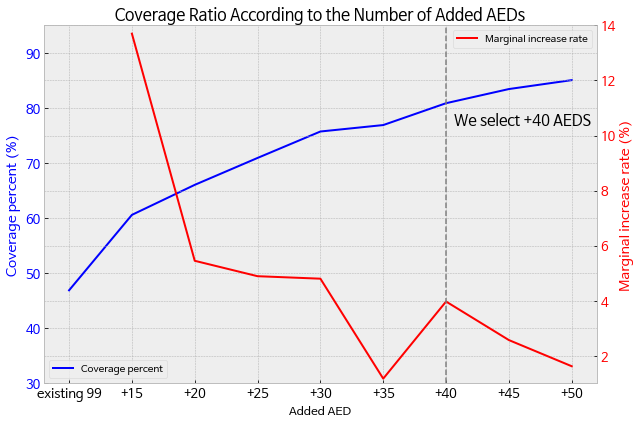

In [21]:
num = ['existing 99', '+15', '+20', '+25', '+30', '+35', '+40', '+45', '+50']
a = [46.89, 60.59, 66.04, 70.93, 75.73, 76.9, 80.87, 83.44, 85.06]
b = [None, 13.7, 19.15, 24.04, 28.84, 30.01, 33.98, 36.55, 38.17]
c = [None, 13.7, 5.45, 4.89, 4.8, 1.17, 3.97, 2.57, 1.62]

coverage = pd.DataFrame([num,a,b,c]).transpose()
coverage.columns = ['Added AED', 'Coverage percent', 'Coverage growth rate', 'Marginal increase rate']

plt.style.use('bmh')

fig, ax1 = plt.subplots(figsize=(9,6))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax1.set_title('Coverage Ratio According to the Number of Added AEDs', fontsize=16)
ax1.set_xlabel('Added AED')
ax1.set_ylabel('Coverage percent (%)', fontsize=14, color='b')
ax1.plot(coverage['Added AED'], coverage['Coverage percent'], color='b', label='Coverage percent')
plt.ylim(30,95)
ax1.tick_params(axis='y', labelcolor='b')
plt.text(6.12,77,'We select +40 AEDS',size=15)

ax2 = ax1.twinx()
ax2.set_ylim(1,14)
ax2.set_ylabel('Marginal increase rate (%)', fontsize=14, color='r')
ax2.plot(coverage['Added AED'], coverage['Marginal increase rate'], color='r', label='Marginal increase rate')
ax2.tick_params(axis='y', labelcolor='r', labelsize=13)
plt.axvline(x='+40', color='gray', linestyle='--', linewidth=1.5)
ax1.legend(loc='lower left')
ax2.legend(loc='upper right')
fig.tight_layout()

## 4. 최종 24시간 가동 AED 시각화
- 추가 AED 위치를 추가한 최종적인 24시간 가동 AED
- 보라색은 기존 AED, 노란색이 추가된 AED
- 기존 130 여개가 커버하고 있던 32% 정도를 40개 만으로 커버 가능
- AED가 필요한 곳에 적절히 배치됨을 확인

In [22]:
# 기존 24시간 AED 
layer1 = pdk.Layer(
    'PolygonLayer',
    aed_24_200,
    get_polygon='buffer_200_coordinates',
    get_fill_color= '[216, 157, 227, 89]',
    get_fill_line=[255, 255, 255, 100],
    pickable=True,
    auto_highlight=True)

layer2 = pdk.Layer(
    "IconLayer",
    aed_24_200,
    get_icon="icon_data",
    get_size=8,
    size_scale=3,
    get_position='[lon, lat]',
    pickable=True,
    auto_highlight=True
)


# 새롭게 추가된 AED 
layer3 = pdk.Layer(
    'PolygonLayer',
    sol,
    get_polygon='buffer_200_coordinates',
    get_fill_color = '[225, 225, 0, 130]',
    get_fill_line = [255, 255, 255, 100],
    pickable=True,
    auto_highlight=True)

layer4 = pdk.Layer(
    'IconLayer',
    sol,
    get_icon="icon_data",
    get_size=8,
    size_scale=3,
    get_position='[lon, lat]',
    pickable=True,
    auto_highlight=True
)

center = [127.0400, 37.5744]
view_state = pdk.ViewState(
    longitude=center[0],
    latitude=center[1],
    zoom=13)

r = pdk.Deck(layers=[layer1, layer2, layer3, layer4], initial_view_state=view_state)
r.to_html('./view.html')

Output hidden; open in https://colab.research.google.com to view.